In [1]:
# importations

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import mpl_toolkits.axes_grid1 as axGrid
import matplotlib as mpl
mpl.style.use("./publication.mplstyle")
%matplotlib tk

from copy import deepcopy

# suivre avancements boucles
from tqdm import tqdm

# parallelisation (mémoire partagée)
from multiprocess import Pool, cpu_count

# module d'éléments finis
from fem2D import *

# module de crétion de maillages simples (carrés et rectangles)
from simpleMeshes import *

# for benchmarking
from time import time

nprocesses = cpu_count()
print(f"Code parallelized with {nprocesses} processes.")

Code parallelized with 12 processes.


In [2]:
# construction du maillage

eraseCurrentMesh()

N = 4       # elements order

Lx = 100000.0   # square size
dx = Lx/20   # elements size
elements, nodes = squareMesh(Lx,dx,N)
Δx = dx/(N+1)

dof = len(nodes)
print(f"Nombre de noeuds : {dof}")
print(f"Soit {2*dof} degré de liberté pour un champ 2D")

Nombre de noeuds : 6561
Soit 13122 degré de liberté pour un champ 2D


In [3]:
plotMesh(elements, nodes)

No handles with labels found to put in legend.


<AxesSubplot:>

In [4]:
# Chargement des points/poids d'intégration de GLL + dérivée des interpolateurs lagrangiens sur ces points

xi,w,dh = readGLL(N)

In [5]:
# Pour chaque élément calcul:
# - du jacobien
# - de l'inverse de la matrice jacobienne
# La transformation depuis un élément quelconque vers l'élément de référence est l'interpolation bilinéaire

duphi = shapeFunctions["P1"]["duphi"]
dvphi = shapeFunctions["P1"]["dvphi"]

def computeJacobian(e):
        
    coords = e.getCoords()
    X, Y = coords[:,0], coords[:,1]
    
    Je11 = np.zeros((N+1,N+1))
    Je21 = np.zeros((N+1,N+1))
    Je12 = np.zeros((N+1,N+1))
    Je22 = np.zeros((N+1,N+1))
    
    e.detJ = np.zeros((N+1,N+1))
    
    e.iJe11 = np.zeros((N+1,N+1))
    e.iJe21 = np.zeros((N+1,N+1))
    e.iJe12 = np.zeros((N+1,N+1))
    e.iJe22 = np.zeros((N+1,N+1))

    dxdu = interp(duphi, X)
    dxdv = interp(dvphi, X)        
    dydu = interp(duphi, Y)
    dydv = interp(dvphi, Y)
    
    
    for i in range(N+1):
        for j in range(N+1):
            
            Je11[i,j] = dxdu(xi[i], xi[j])
            Je21[i,j] = dxdv(xi[i], xi[j])
            Je12[i,j] = dydu(xi[i], xi[j])
            Je22[i,j] = dydv(xi[i], xi[j])
            
            e.detJ[i,j] = Je11[i,j]*Je22[i,j] - Je21[i,j]*Je12[i,j]
            
            e.iJe11[i,j] =  Je22[i,j]/e.detJ[i,j]
            e.iJe22[i,j] =  Je11[i,j]/e.detJ[i,j]
            e.iJe21[i,j] = -Je21[i,j]/e.detJ[i,j]
            e.iJe12[i,j] = -Je12[i,j]/e.detJ[i,j]
            
    return e
    
print("Calcul du jacobien et de l'inverse de la matrice jacobienne:")

with Pool(nprocesses) as p:
    Element.id = 0
    elements = list(tqdm(p.imap(computeJacobian, elements), total=len(elements)))

Calcul du jacobien et de l'inverse de la matrice jacobienne:


100%|██████████| 400/400 [00:00<00:00, 434.85it/s]


In [6]:
# paramètres mécaniques béton

E = 30e9        # module d'Young
ν = 0.25        # coefficient de Poisson

# paramètres de Lamé
λ = (E*ν) / ((1+ν)*(1-2*ν))
μ = E / (2*(1+ν))

# masse volumique
ρ = 2500.0

# vitesses d'ondes
vp = np.sqrt((λ+2*μ)/ρ)
vs =np.sqrt(μ/ρ)

print(f"Vitesse des ondes P : {vp/1000:.3f}km/s")
print(f"Vitesse des ondes S : {vs/1000:.3f}km/s")


Vitesse des ondes P : 3.795km/s
Vitesse des ondes S : 2.191km/s


In [7]:
# calcul des matrices élémentaires

δ = np.eye(N+1)

def computeStiffnes(e):
    
    # KeTemp = np.zeros((N+1,N+1,N+1,N+1))
    e.Ke = np.zeros((2*(N+1)**2,2*(N+1)**2))
    
    Kdxdx = np.zeros((N+1,N+1,N+1,N+1))
    Kdydy = np.zeros((N+1,N+1,N+1,N+1))
    Kdxdy = np.zeros((N+1,N+1,N+1,N+1))
    Kdydx = np.zeros((N+1,N+1,N+1,N+1))
    
    for a in range(N+1):
        for b in range(N+1):
            for c in range(N+1):
                for d in range(N+1):
                       
                        for p in range(N+1):
                            for q in range(N+1):
                                
                                Kdxdx[a,b,c,d] += w[p]*w[q] * (e.iJe11[p,q]*dh[a,p]*δ[b,q] + e.iJe12[p,q]*dh[b,q]*δ[a,p])*(e.iJe11[p,q]*dh[c,p]*δ[d,q] + e.iJe12[p,q]*dh[d,q]*δ[c,p]) * e.detJ[p,q]
                                Kdydy[a,b,c,d] += w[p]*w[q] * (e.iJe21[p,q]*dh[a,p]*δ[b,q] + e.iJe22[p,q]*dh[b,q]*δ[a,p])*(e.iJe21[p,q]*dh[c,p]*δ[d,q] + e.iJe22[p,q]*dh[d,q]*δ[c,p]) * e.detJ[p,q]
                                Kdxdy[a,b,c,d] += w[p]*w[q] * (e.iJe11[p,q]*dh[a,p]*δ[b,q] + e.iJe12[p,q]*dh[b,q]*δ[a,p])*(e.iJe21[p,q]*dh[c,p]*δ[d,q] + e.iJe22[p,q]*dh[d,q]*δ[c,p]) * e.detJ[p,q]
                                Kdydx[a,b,c,d] += w[p]*w[q] * (e.iJe21[p,q]*dh[a,p]*δ[b,q] + e.iJe22[p,q]*dh[b,q]*δ[a,p])*(e.iJe21[p,q]*dh[c,p]*δ[d,q] + e.iJe22[p,q]*dh[d,q]*δ[c,p]) * e.detJ[p,q]
                                
    for i in range(2*(N+1)**2):
        for j in range(2*(N+1)**2):
            
            a,b = i//2//(N+1), i//2%(N+1)
            c,d = j//2//(N+1), j//2%(N+1)
            
            if i%2 == 0 and j%2 == 0:
                
                e.Ke[i,j] = (2*λ+μ)*Kdxdx[a,b,c,d] + μ*Kdydy[a,b,c,d]             
                
            if i%2 == 0 and j%2 != 0:
                
                e.Ke[i,j] = λ*Kdxdy[a,b,c,d] + μ*Kdydx[a,b,c,d]      
            
            if i%2 != 0 and j%2 == 0:
                
                e.Ke[i,j] = λ*Kdydx[a,b,c,d] + μ*Kdxdy[a,b,c,d]             
                
            if i%2 != 0 and j%2 != 0:
                
                e.Ke[i,j] = (2*λ+μ)*Kdydy[a,b,c,d] + μ*Kdxdx[a,b,c,d] 
                                
    return e


print("Calcul des matrices de rigidité (stiffness) élémentaires:")

with Pool(nprocesses) as p:
    Element.id = 0
    elements = list(tqdm(p.imap(computeStiffnes, elements), total=len(elements)))

Calcul des matrices de rigidité (stiffness) élémentaires:


100%|██████████| 400/400 [00:09<00:00, 41.75it/s]


In [8]:
# calcul des matrices élémentaires de masse
print("Calcul des matrices de masse élémentaires:")

for e in tqdm(elements):
    
    e.Me = np.zeros(2*(N+1)**2) # diagonal
    
    for i in range(2*(N+1)**2):
        e.Me[i] = ρ * w[i//2//(N+1)]*w[i//2%(N+1)]*e.detJ[i//2//(N+1),i//2%(N+1)]


Calcul des matrices de masse élémentaires:


100%|██████████| 400/400 [00:00<00:00, 18342.77it/s]
invalid command name "139968056873856delayed_destroy"
    while executing
"139968056873856delayed_destroy"
    ("after" script)
invalid command name "139968056794688delayed_destroy"
    while executing
"139968056794688delayed_destroy"
    ("after" script)
invalid command name "139968056878848delayed_destroy"
    while executing
"139968056878848delayed_destroy"
    ("after" script)
invalid command name "139968056873472delayed_destroy"
    while executing
"139968056873472delayed_destroy"
    ("after" script)


In [9]:
# assemblage

print("Assemblage des matrices globales K et M:")


K = np.zeros((2*dof,2*dof))
M = np.zeros(2*dof)

for e in tqdm(elements):
    for (i,n1) in enumerate(e.nodes):
        M[2*n1.id] += e.Me[2*i]
        M[2*n1.id+1] += e.Me[2*i+1]
        for (j,n2) in enumerate(e.nodes):
            K[2*n1.id,2*n2.id] += e.Ke[2*i,2*j]
            K[2*n1.id+1,2*n2.id] += e.Ke[2*i+1,2*j]
            K[2*n1.id,2*n2.id+1] += e.Ke[2*i,2*j+1]
            K[2*n1.id+1,2*n2.id+1] += e.Ke[2*i+1,2*j+1]

Assemblage des matrices globales K et M:


100%|██████████| 400/400 [00:00<00:00, 536.22it/s]


In [12]:
# inverting mass matrix
iM = 1/M

In [13]:
# résolution temporelle

Nit = 2000
cfl = 0.125
Δt = Δx/vp* cfl
T = Δt*Nit 

timeSim = np.linspace(0,T,Nit)

U = np.zeros((Nit, 2*dof))
dU = np.zeros((Nit, 2*dof))
ddU = np.zeros((Nit, 2*dof))

F = np.zeros(2*dof)

t0 = T/7.0         # tuning
f0 = vs/(5*Δx)     # tuning
f = lambda t : (4*(t-t0)**2*f0**4 - 2*f0**2)*np.exp(-(t-t0)**2*f0**2)
noeudSource = getCenterNode(nodes)


In [14]:
# tests sur valeurs paramètres
print(f"CFL = {Δt/Δx*vp:.4g}")
print(f"Longeur d'onde pertubation grande devant distance internoeuds : Δx = {Δx}m while λmin ~ {vs/(4*f0):.4g}m")

CFL = 0.125
Longeur d'onde pertubation grande devant distance internoeuds : Δx = 1000.0m while λmin ~ 1250m


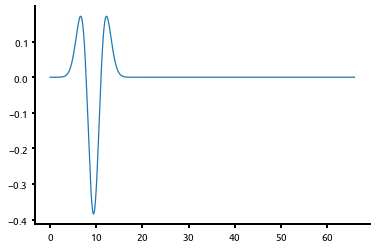

In [15]:
%matplotlib inline
plt.plot(timeSim, f(timeSim))

In [16]:
# source = force simple selon 1 direction

U[:,:] = 0.0
dU[:,:] = 0.0
ddU[:,:] = 0.0
F[:] = 0.0

timeIt = np.zeros(Nit-2)

# Displacement base scheme

# for i in range(2,Nit):
#     t = time()
#     F[2*noeudSource] = f(i*Δt)
#     U[i,:] = 2*U[i-1,:] - U[i-2,:] + Δt**2*np.multiply(iM , F - K@U[i-1,:])
#     timeIt[i-2] = time() - t
#     print(f"\rIteration {i}/{Nit} - timeIt = {time() - t:.4f}s", end="")                          
# print(f"\rMean iteration time = {np.mean(timeIt):.4f}s")


# Newmark scheme

for i in range(2,Nit):
    t = time()
    F[2*noeudSource] = f(i*Δt)
    U[i,:] = U[i-1,:] + Δt*dU[i-1,:] + Δt**2/2*ddU[i-1,:]
    ddU[i,:] = np.multiply(iM, F - K@U[i,:])
    dU[i,:] = dU[i-1,:] + Δt/2*(ddU[i-1,:] + ddU[i,:])
    timeIt[i-2] = time() - t
    print(f"\rIteration {i}/{Nit} - timeIt = {time() - t:.4f}s", end="")                          
print(f"\rMean iteration time = {np.mean(timeIt):.4f}s")

Mean iteration time = 0.0257s= 0.0262s


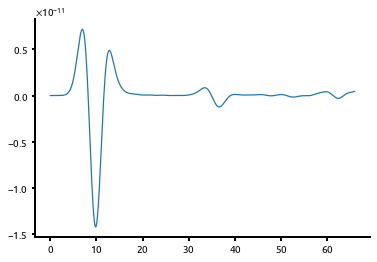

In [17]:
%matplotlib inline
plt.plot(timeSim, U[:,2*noeudSource])

In [18]:
%matplotlib tk

fig, ax = plt.subplots()
ax.set_aspect("equal", "box")

# plotMeshLimits(elements, ax)

displ = U[:,::2]

dmin = min(displ.min(), -displ.max())/3
dmin = -1e-12

dots = ax.scatter([n.x for n in nodes], [n.y for n in nodes], c=displ[0,:], zorder=4, cmap="seismic", vmin=dmin, vmax=-dmin)

cbar = plt.colorbar(dots)
ttl = ax.annotate("it = 0", xy=(0.05, 0.05), xycoords='axes fraction', bbox=dict(facecolor='white', edgecolor='grey'), zorder=5)

dit = 10

def animate(i):
    dots.set_array(displ[dit*i,:])
    cbar.update_normal(dots)
    ttl.set_text(f"it = {dit*i}")
    return dots,ttl,

ani = animation.FuncAnimation(fig, animate, interval=30, blit=True, frames = int(Nit/dit))

ani.event_source.start()
plt.show()

# file = "../figures/OndeElastiqueSquare.mp4"
# writer = animation.FFMpegWriter(fps=15, bitrate=-1) 

# ani.save(file, writer=writer, dpi = 500)